In [2]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose as mlr
import matplotlib.pyplot as plt
import numpy as np
import time
import heapq
from itertools import groupby
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from statistics import mean
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.feature_selection import SelectFromModel
import scipy as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from scipy.stats import kurtosis
scaler = MinMaxScaler()
lb = LabelBinarizer()
%matplotlib inline

In [10]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)


In [24]:
import math
hDF = pd.read_csv('./housing/data.csv', index_col=0)
hDF.dropna(inplace=True)
print(len(set(hDF['MEDV'])))
houseY = hDF['MEDV']
print(len(hDF))

houseY = [math.trunc(y) for y in houseY]
hDF = hDF.drop(['MEDV'],axis=1)
print(len(hDF))
hDF[:] = scaler.fit_transform(hDF[:])


230
506
506


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(
hDF, houseY, test_size=0.4)

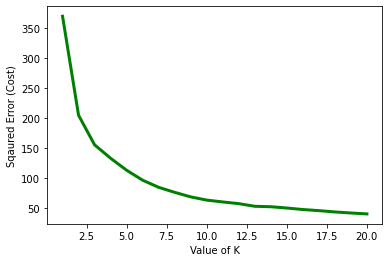

In [6]:
cost =[]
for i in range(1, 21):
    KM = KMeans(init='k-means++', n_clusters = i, max_iter = 500)
    KM.fit(hDF)
      
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)     
  
# plot the cost against K values
plt.plot(range(1, 21), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

For n_clusters = 2 The average silhouette_score is : 0.4517911156927882
For n_clusters = 3 The average silhouette_score is : 0.3275318724312192
For n_clusters = 4 The average silhouette_score is : 0.3474425983997603
For n_clusters = 5 The average silhouette_score is : 0.3544696240081055
For n_clusters = 6 The average silhouette_score is : 0.3563829519280547
For n_clusters = 7 The average silhouette_score is : 0.33496384966301357
For n_clusters = 8 The average silhouette_score is : 0.34360589304595157
For n_clusters = 9 The average silhouette_score is : 0.3611241368908252
For n_clusters = 10 The average silhouette_score is : 0.3713640878645867
For n_clusters = 11 The average silhouette_score is : 0.36808582612724694
For n_clusters = 12 The average silhouette_score is : 0.3533470211621073
For n_clusters = 13 The average silhouette_score is : 0.3229359816850209
For n_clusters = 14 The average silhouette_score is : 0.34753996106629664
For n_clusters = 15 The average silhouette_score is : 0

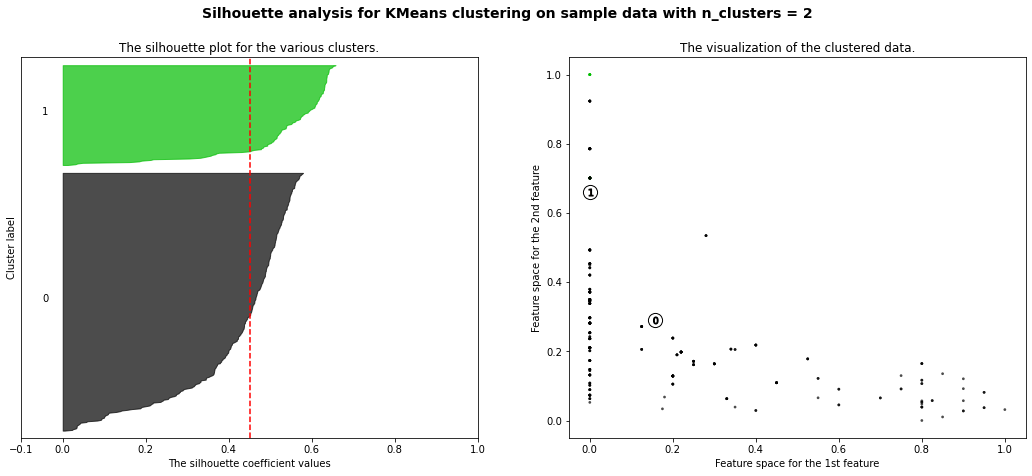

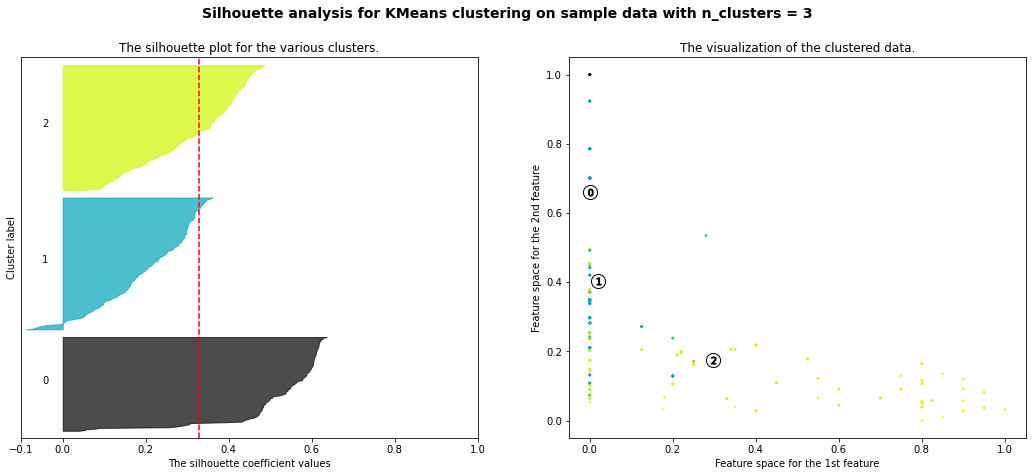

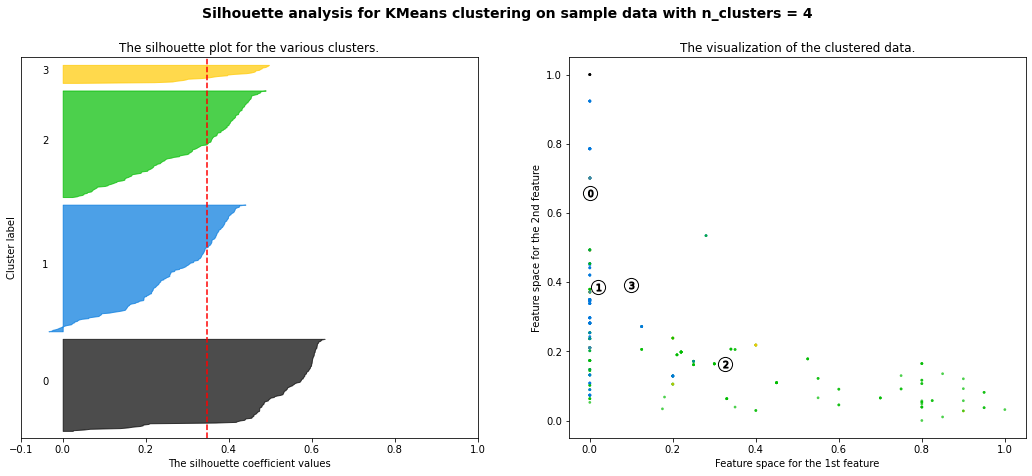

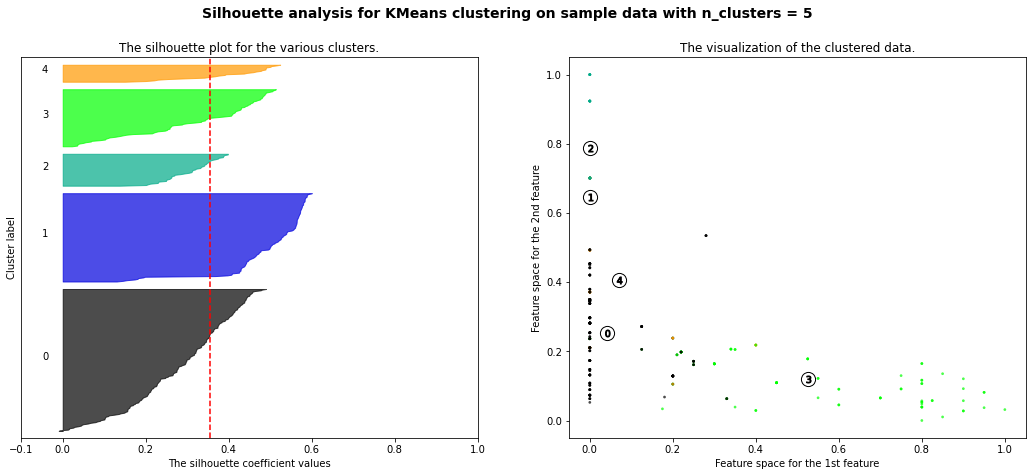

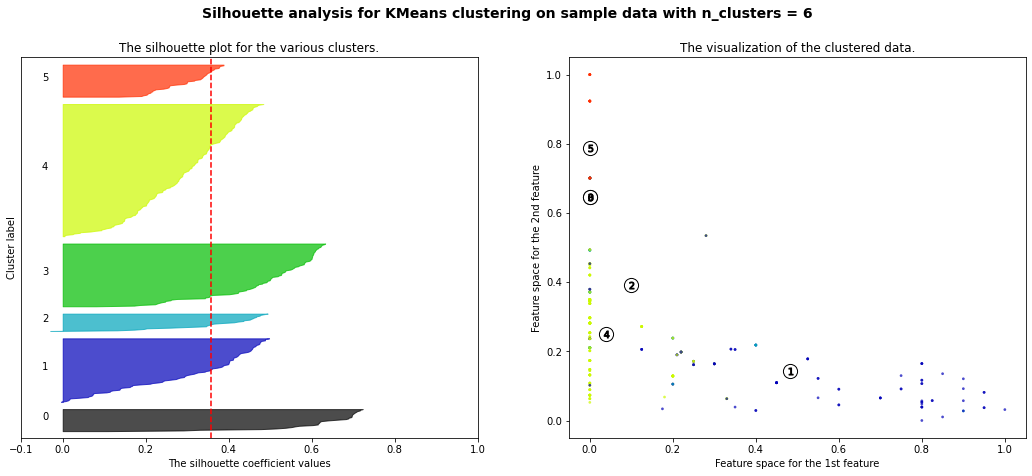

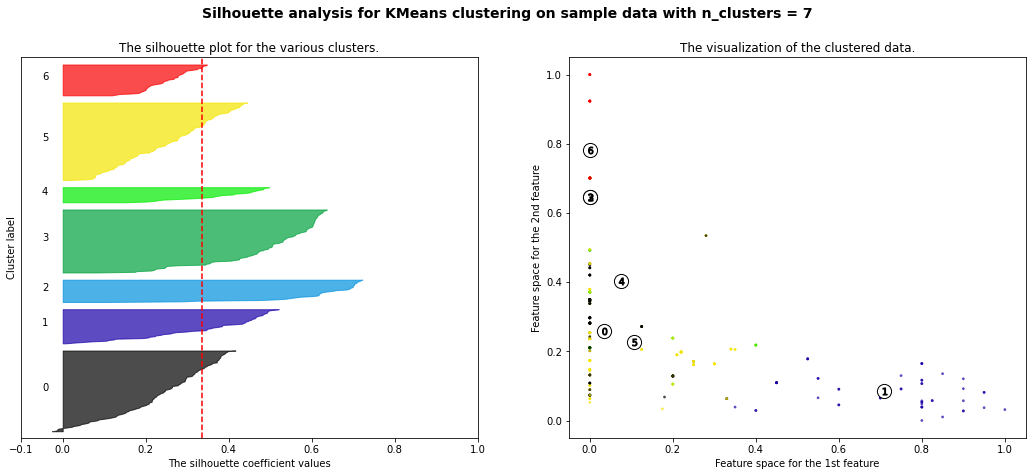

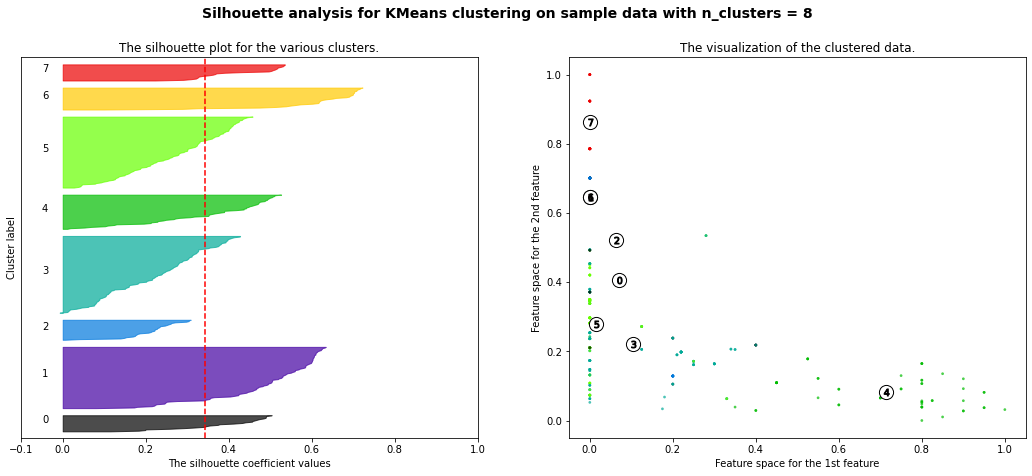

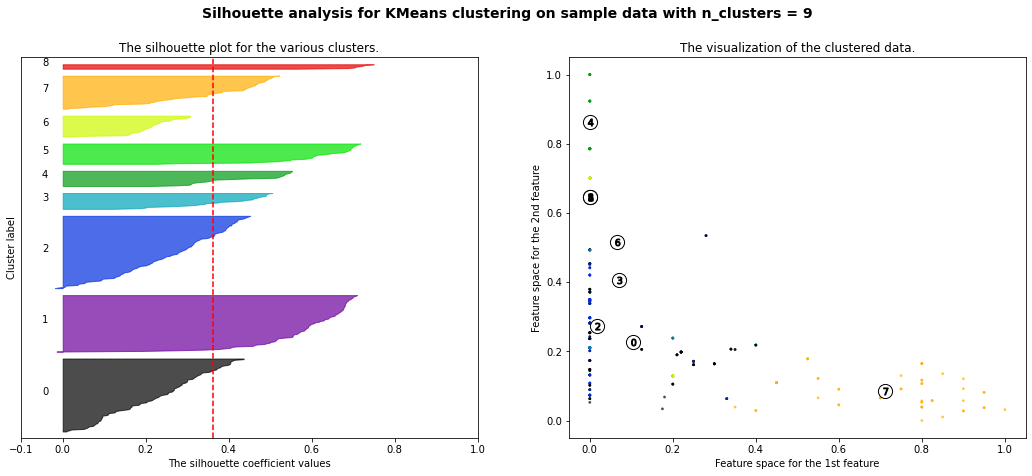

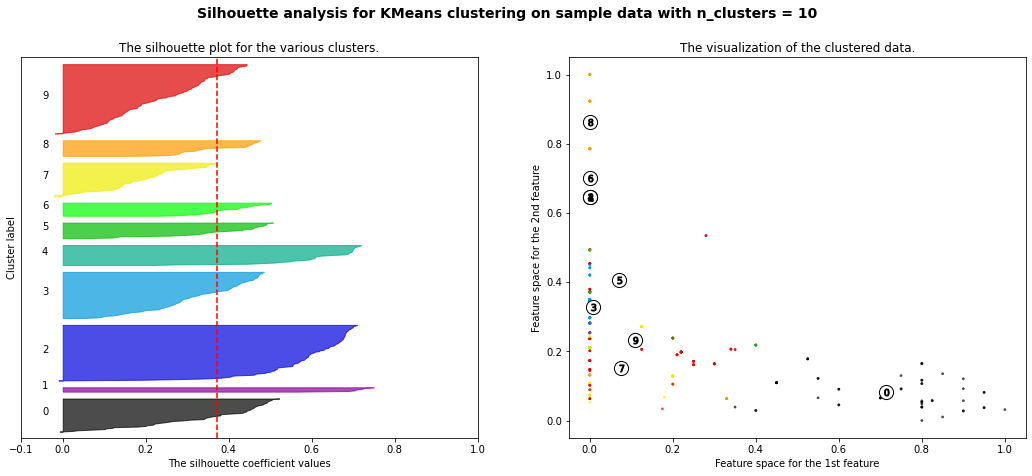

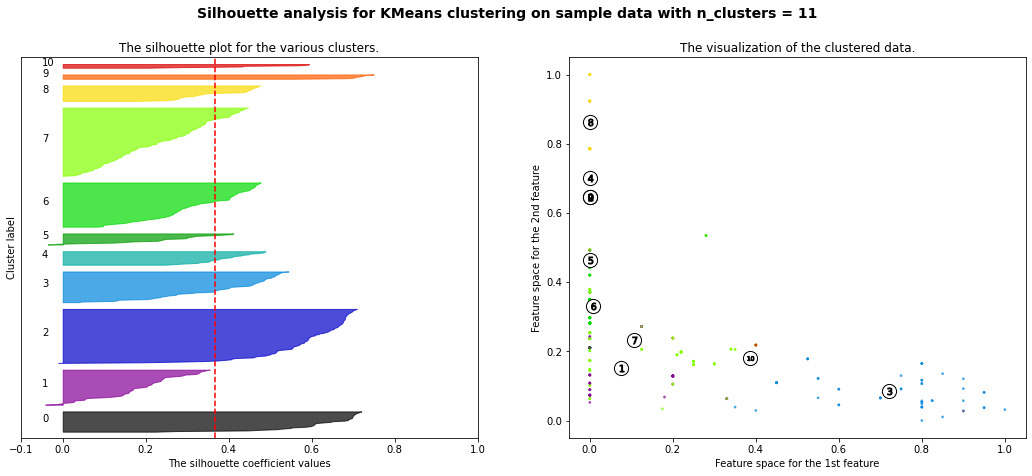

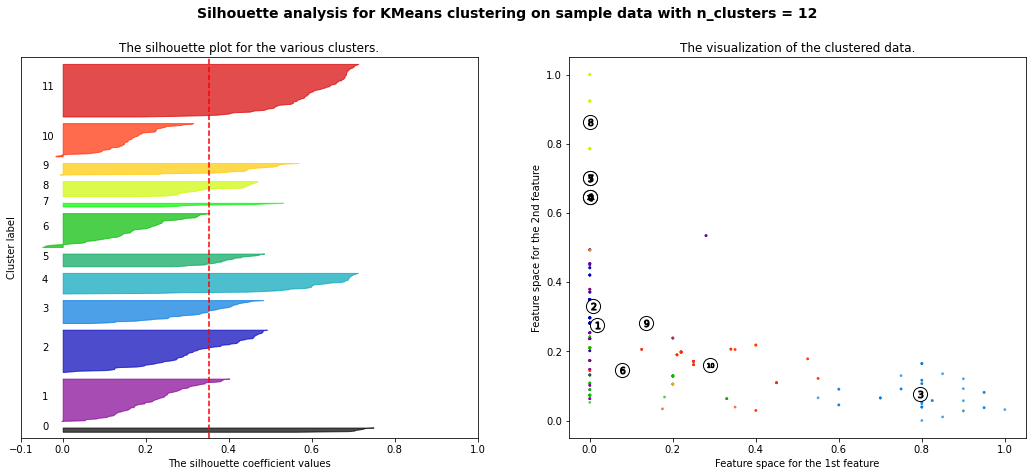

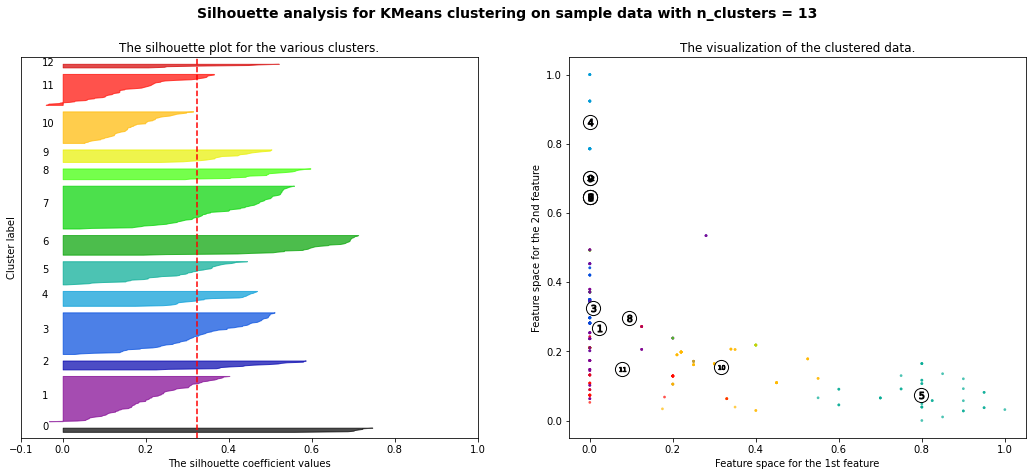

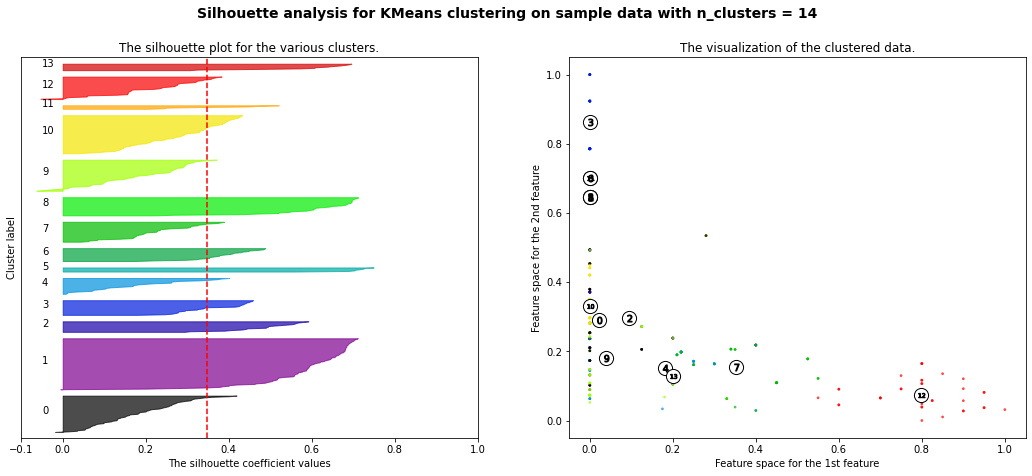

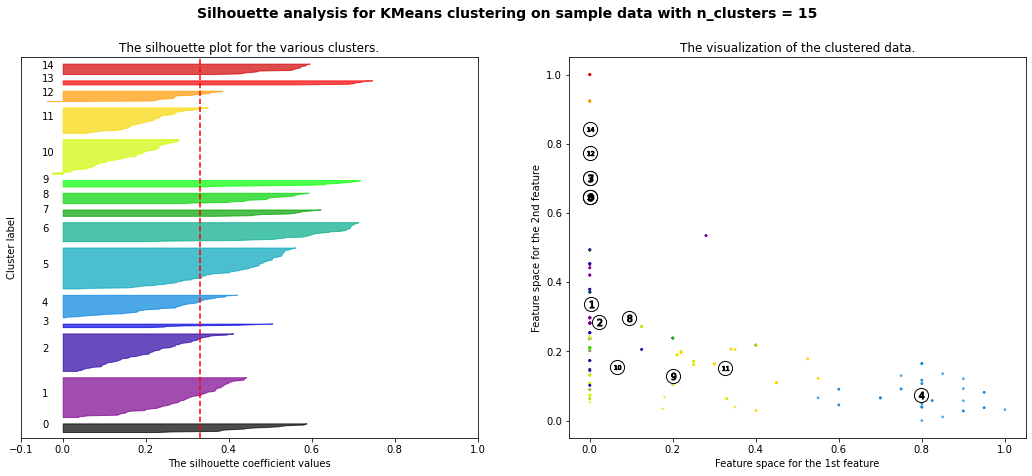

In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
for n_clusters in range(2,16):
    X_sample = hDF.sample(500).to_numpy()
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_sample) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(init='k-means++',n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_sample)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_sample, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_sample, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_sample[:, 0], X_sample[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [58]:
print(len(houseY))
print(len(hDF))

506
506


No handles with labels found to put in legend.
[[ 15.272543  -10.614809  -62.277813 ]
 [ 18.257603   -3.7840881  27.720087 ]
 [ 19.098352   16.758549   71.22654  ]
 ...
 [-23.576616  -29.729647  -25.527617 ]
 [  9.807199   43.17523   -46.15406  ]
 [ -8.201533  -11.906404  -60.421246 ]]


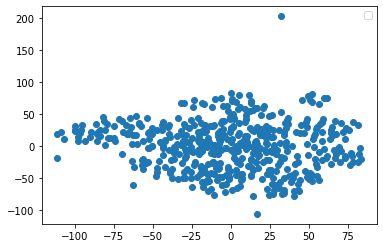

In [16]:
tsne = TSNE(n_components=3, perplexity=30)
X_2d = tsne.fit_transform(hDF.sample(500))

print(X_2d)
plt.scatter(X_2d[:,0],X_2d[:,1])
plt.legend()
plt.show()

Text(0.5, 1.0, 'Gap Statistic vs. K')

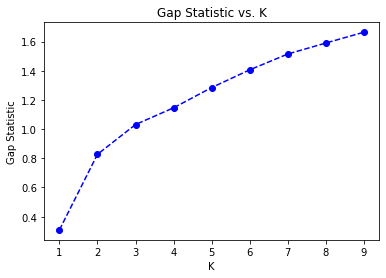

In [12]:
score_g, df = optimalK(hDF, nrefs=5, maxClusters=10)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs. K')

In [37]:
t0 = time.time()
kmeans = KMeans(init='k-means++', n_clusters=2)
houseLabelsBasicKmeans = kmeans.fit_predict(hDF)
t_batch = time.time() - t0
print(t_batch)

0.043874502182006836


In [38]:
t0 = time.time()
em = GaussianMixture(2)
houseLabelsBasicEM = em.fit_predict(hDF)
t_batch = time.time() - t0
print(t_batch)

0.01795172691345215


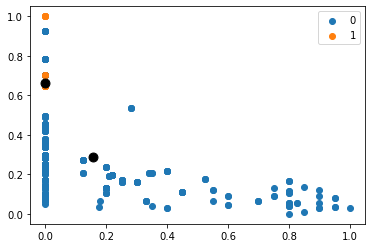

In [43]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(houseLabelsBasicKmeans)

#plotting the results:
 
for i in u_labels:
    plt.scatter(hDF.to_numpy()[houseLabelsBasicKmeans == i , 0] , hDF.to_numpy()[houseLabelsBasicKmeans == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [32]:
mean(houseY) # 22.29644
houseYthresh = list(map( lambda x: 1 if x < np.median(houseY) else 0, houseY))


In [83]:
print(len(houseLabelsBasicKmeans))
print(sp.spatial.distance.hamming(houseLabelsBasicKmeans, houseYthresh))

506
0.30434782608695654


In [15]:
dtHouse = DecisionTreeClassifier()
pcaHouse  = PCA()
icaHouse  = FastICA()
selcaHouse  = SelectFromModel(dtHouse)
pcaXHouse  = pcaHouse.fit_transform(hDF)
icaXHouse  = icaHouse.fit_transform(hDF)

In [16]:
rcaHouse = GaussianRandomProjection(n_components=10)
rcaXHouse = rcaHouse.fit_transform(hDF)


In [17]:
selcaXHouse = selcaHouse.fit_transform(hDF, houseY)

In [148]:
testRCAs = []
for i in range(100):
    rcaTHouse = GaussianRandomProjection(n_components=10)
    testRCAs.append(rcaTHouse.fit_transform(hDF))

testRCAdists = []
for test in testRCAs:
    for test2 in testRCAs:
        a = np.hstack(test)
        b = np.hstack(test2)

        testRCAdists.append(distance.cosine(a,b))
np.mean(testRCAdists)

0.9925881502221149

In [92]:
t0 = time.time()
houseclfPCAKmeans= KMeans(init='k-means++', n_clusters=2)
houseLabelsPCAKmeans = clf.fit_predict(pcaXHouse)
t_batch = time.time() - t0
print(t_batch)

t0 = time.time()
houseclfICAKmeans = KMeans(init='k-means++', n_clusters=2)
houseLabelsICAKmeans = clf.fit_predict(icaXHouse)
t_batch = time.time() - t0
print(t_batch)

t0 = time.time()
houseclfRCAKmeans = KMeans(init='k-means++', n_clusters=2)
houseLabelsRCAKmeans = clf.fit_predict(rcaXHouse)
t_batch = time.time() - t0
print(t_batch)

t0 = time.time()
houseclfSEKCAKmeans = KMeans(init='k-means++', n_clusters=2)
houseLabelsSELCAKmeans = clf.fit_predict(selcaXHouse)
t_batch = time.time() - t0
print(t_batch)


0.09873747825622559
0.11168432235717773
0.0857696533203125
0.07280516624450684


Text(0.5, 0, 'Distribution of Largest Eigenvalues')

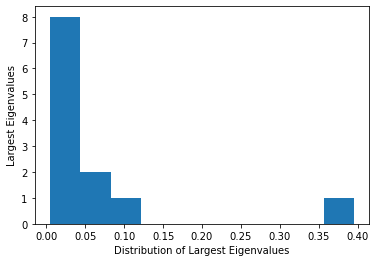

In [96]:
plt.hist(pcaHouse.explained_variance_)
plt.ylabel('Largest Eigenvalues')
plt.xlabel('Distribution of Largest Eigenvalues')

In [122]:
# np.linalg.norm(hDF.to_numpy(), pcaHouse.inverse_transform(pcaXHouse))
from scipy.spatial import distance

Aflat = np.hstack(hDF.to_numpy())
Bflat = np.hstack(pcaHouse.inverse_transform(pcaXHouse))

dist = distance.cosine(Aflat, Bflat)
print(dist)

0.0


Text(0, 0.5, 'Mean Kurtosis across components')

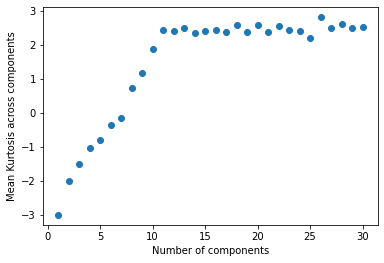

In [137]:
kurtMeans = []
for i in range(1,31):
    icaTHouse = FastICA(n_components = i)
    icaTHouseX = icaTHouse.fit_transform(hDF)
    kurts = kurtosis(icaTHouse.components_)
    kurtMeans.append(np.mean(kurts))
plt.scatter(range(1,31), kurtMeans)
plt.xlabel('Number of components')
plt.ylabel('Mean Kurtosis across components')

Text(0, 0.5, 'Kurtosis Value')

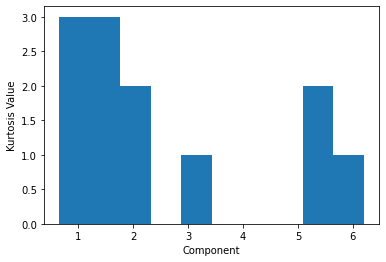

In [130]:
kurts = kurtosis(icaHouse.components_)
plt.hist(kurts)
plt.xlabel("Component")
plt.ylabel("Kurtosis Value")

In [138]:
from scipy.spatial import distance

Aflat = np.hstack(hDF.to_numpy())
Bflat = np.hstack(icaHouse.inverse_transform(icaXHouse))

dist = distance.cosine(Aflat, Bflat)
print(dist)

0.24320629777261749


In [26]:
# sns.pairplot(hDF)

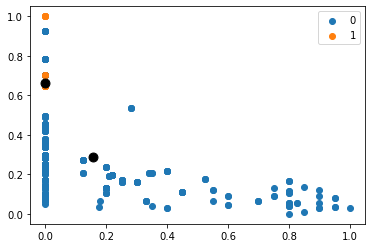

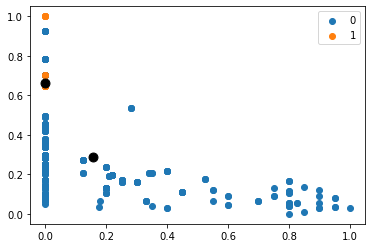

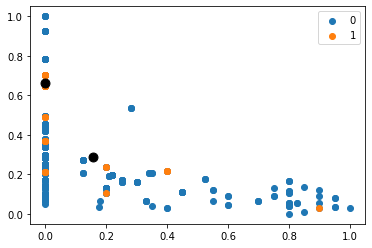

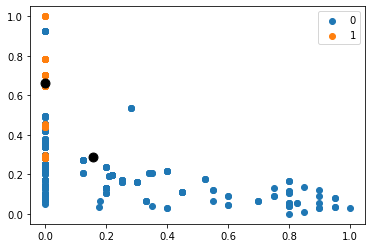

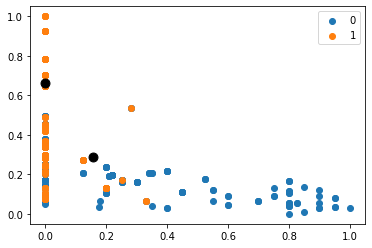

In [46]:
houseLabelsKmeans = [houseLabelsBasicKmeans, houseLabelsPCAKmeans, houseLabelsICAKmeans, houseLabelsRCAKmeans, houseLabelsSELCAKmeans]
for labelset in houseLabelsKmeans:
    #Getting the Centroids
    centroids = kmeans.cluster_centers_
    u_labels = np.unique(labelset)

    #plotting the results:
    
    for i in u_labels:
        plt.scatter(hDF.to_numpy()[labelset == i , 0] , hDF.to_numpy()[labelset == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.show()

In [84]:
print(sp.spatial.distance.hamming(houseLabelsSELCAKmeans, houseYthresh))

0.30039525691699603


In [87]:
t0 = time.time()
houseclfPCAEM = GaussianMixture(2)
houseLabelsPCAEM = clf.fit_predict(pcaXHouse)
t_batch = time.time() - t0
print(t_batch)

t0 = time.time()
houseclfICAEM = GaussianMixture(2)
houseLabelsICAEM = clf.fit_predict(icaXHouse)
t_batch = time.time() - t0
print(t_batch)

t0 = time.time()
houseclfRCAEM = GaussianMixture(2)
houseLabelsRCAEM = clf.fit_predict(rcaXHouse)
t_batch = time.time() - t0
print(t_batch)

t0 = time.time()
houseclfSELCAEM = GaussianMixture(2)
houseLabelsSELCAEM = clf.fit_predict(selcaXHouse)
t_batch = time.time() - t0
print(t_batch)

0.07679176330566406
0.17253947257995605
0.10471940040588379
0.10472249984741211


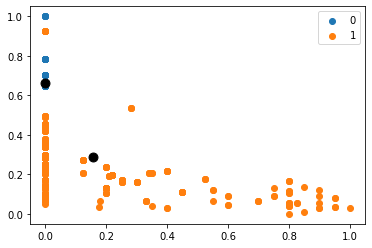

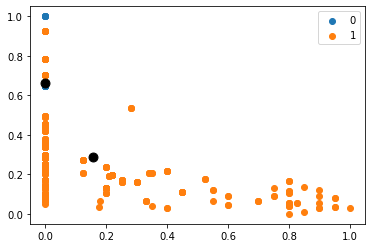

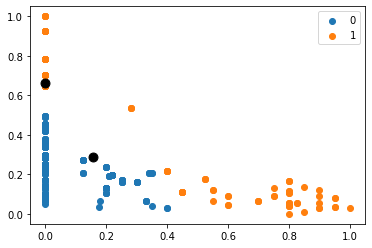

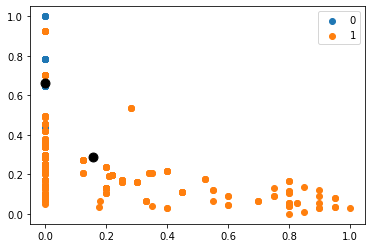

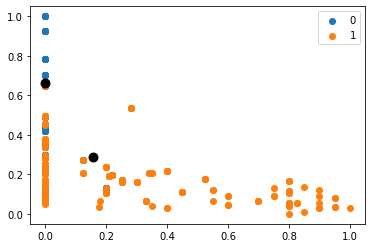

In [88]:
houseLabelsEM = [houseLabelsBasicEM, houseLabelsPCAEM, houseLabelsICAEM, houseLabelsRCAEM, houseLabelsSELCAEM]
for labelset in houseLabelsEM:
    #plotting the results:
    
    for i in u_labels:
        plt.scatter(hDF.to_numpy()[labelset == i , 0] , hDF.to_numpy()[labelset == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.show()

In [90]:
print(sp.spatial.distance.hamming(houseLabelsBasicEM, houseYthresh))
print(sp.spatial.distance.hamming(houseLabelsICAEM, houseYthresh))

0.717391304347826
0.3616600790513834


In [28]:
mlpTest = MLPClassifier()
param_grid = [
  {
  'alpha': [0.00001, 0.0001, 0.003, 0.001, 0.01], 
  'activation': ['identity', 'logistic', 'tanh', 'relu'],
  'hidden_layer_sizes': [(150,100,50), (100,50,25), (300,200,100), (150,100), (150,100,50, 25), (25,10,5), (25,10), (50), (10), (25), (25,10), (300, 150, 100, 50, 25)] 
  }
 ]
gscvTrain = GridSearchCV(mlpTest, param_grid)
gscvTrain.fit(X_train, Y_train)

GridSearchCV(estimator=MLPClassifier(),
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                                         'relu'],
                          'alpha': [1e-05, 0.0001, 0.003, 0.001, 0.01],
                          'hidden_layer_sizes': [(150, 100, 50), (100, 50, 25),
                                                 (300, 200, 100), (150, 100),
                                                 (150, 100, 50, 25),
                                                 (25, 10, 5), (25, 10), 50, 10,
                                                 25, (25, 10),
                                                 (300, 150, 100, 50, 25)]}])

In [21]:
houseTransformedData = [pcaXHouse,icaXHouse,rcaXHouse,selcaXHouse]
titles = ['PCA', 'ICA', 'RP', 'DT Selection']

In [29]:
print(gscvTrain.best_estimator_.alpha)
print(gscvTrain.best_estimator_.activation)
print(gscvTrain.best_estimator_.hidden_layer_sizes)

0.003
tanh
(300, 150, 100, 50, 25)


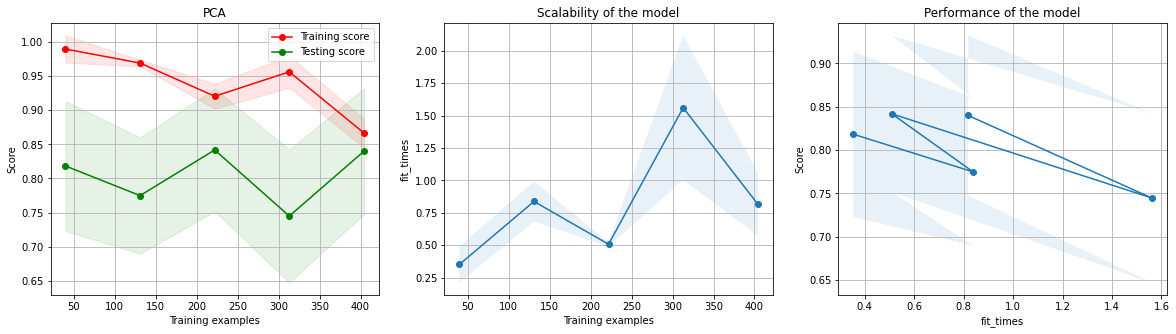

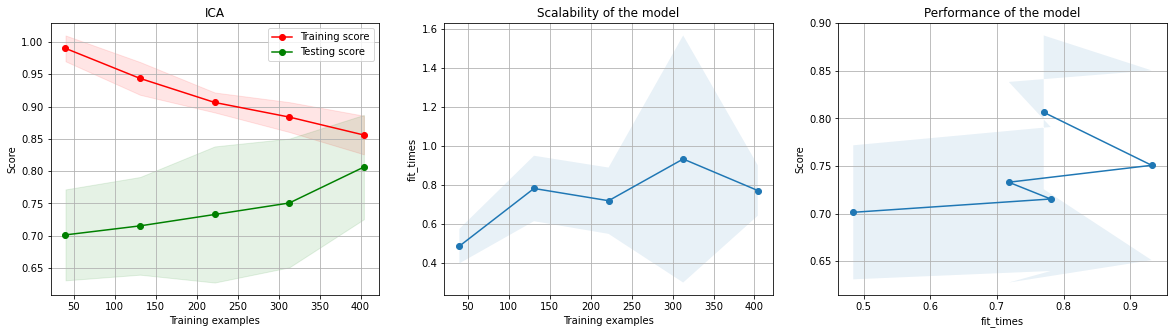

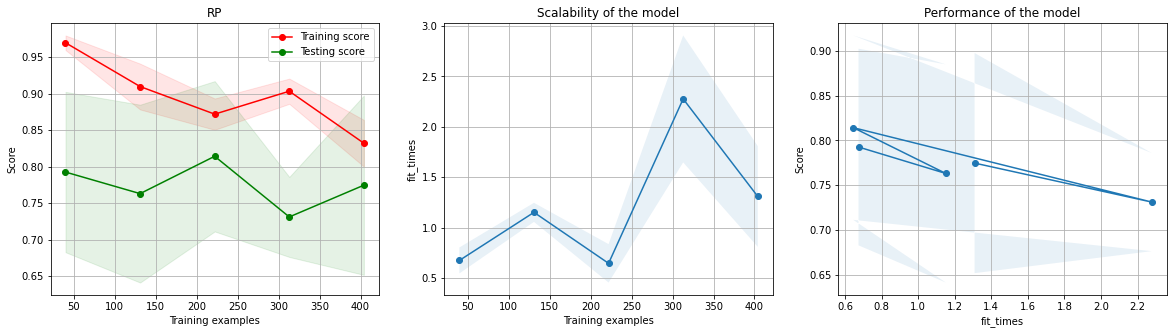

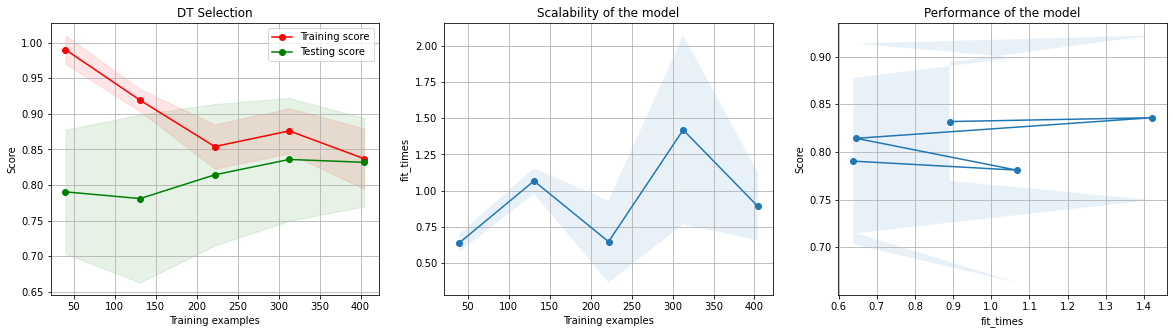

In [33]:
for i in range(len( houseTransformedData )):
    mlp = MLPClassifier(hidden_layer_sizes=(300, 150, 100, 50, 25), activation = 'tanh',alpha = 0.003, solver='adam',random_state=1)
    plot_learning_curve(mlp, titles[i], houseTransformedData[i], houseYthresh, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

<module 'matplotlib.pyplot' from 'C:\\Users\\Raj\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

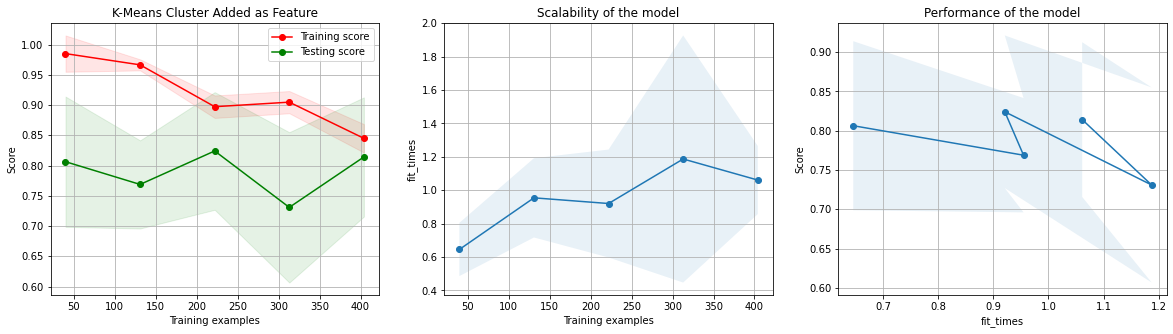

In [41]:
mlp =  MLPClassifier(hidden_layer_sizes=(300, 150, 100, 50, 25), activation = 'tanh',alpha = 0.003, solver='adam',random_state=1)
plot_learning_curve(mlp, 'K-Means Cluster Added as Feature', hDF, houseYthresh, axes=None, ylim=None, cv=None,
                    n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

<module 'matplotlib.pyplot' from 'C:\\Users\\Raj\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

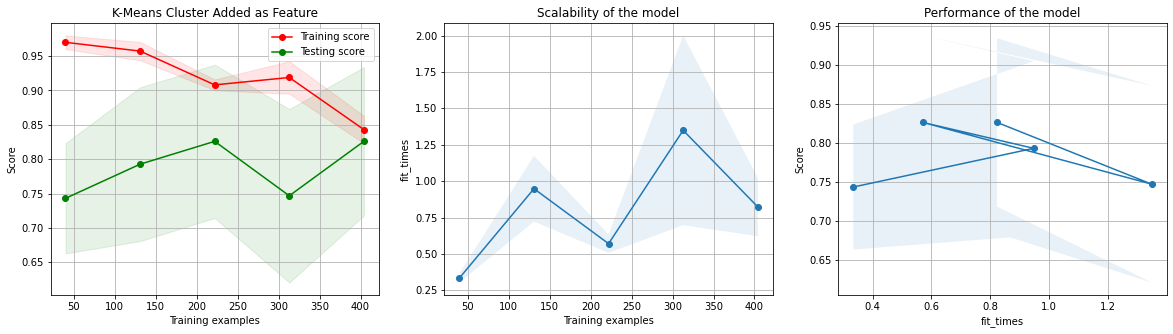

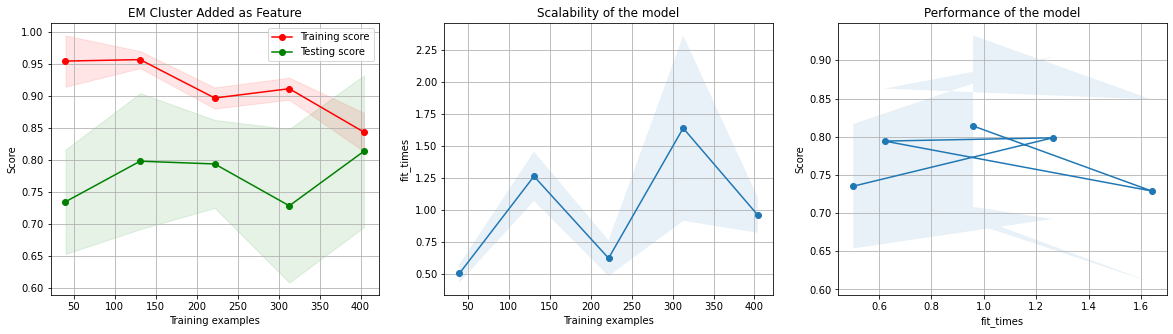

In [40]:
mlp =  MLPClassifier(hidden_layer_sizes=(300, 150, 100, 50, 25), activation = 'tanh',alpha = 0.003, solver='adam',random_state=1)
X_new = hDF.copy()
mlkmdf = pd.DataFrame(houseLabelsBasicKmeans, columns = ['kmeansLabels'])
X_new = X_new.reset_index()
X_new = pd.concat([X_new,  mlkmdf], axis=1)
plot_learning_curve(mlp, 'K-Means Cluster Added as Feature', X_new, houseYthresh, axes=None, ylim=None, cv=None,
                    n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

mlp =  MLPClassifier(hidden_layer_sizes=(300, 150, 100, 50, 25), activation = 'tanh',alpha = 0.003, solver='adam',random_state=1)
X_new = hDF.copy()
mlemdf = pd.DataFrame(houseLabelsBasicEM, columns = ['EMLabels'])
X_new = X_new.reset_index()
X_new = pd.concat([X_new,  mlemdf], axis=1)
plot_learning_curve(mlp, 'EM Cluster Added as Feature', X_new, houseYthresh, axes=None, ylim=None, cv=None,
                    n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

In [8]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

        """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       scoring='accuracy'
                       )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Testing score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [103]:
print("Variance: %r " % get_variance(Y_train))


Variance: 0.1837847628010746 


In [51]:
from mlxtend.evaluate import bias_variance_decomp

In [100]:
def get_bias(predicted_values, true_values):
    return np.mean((predicted_values - true_values) ** 2)
def get_variance(values):
    return np.var(values)
